## TSP con restricciones (puede fijarse la ciudad de partida o de destino, para acotar combinaciones no válidas)

#### **Estrategias para definir o evitar restricciones:**

* Generar una función que genere o verifique que los individuos sean válidos
* **Eliminar los individuos no válidos**
* Individuos de reserva
* **Generar más hijos para tener suficientes hijos válidos**
* Mutación heurística a una subcadena que busca individuos válidos

* **Matriz tabú (lista de pares de individuos o combinaciones no válidas)**
* **Shift genético (mover gen hasta encontrar par válido)**
* **Validación de cromosoma cada nuevo individuo**
* **Penalización de cromosomas no válidos (muy baja aptitud para evitar que sea cruzado), por ejemplo, desde 2n veces la aptitud mínima, máxima o promedio inicial de la población**



In [20]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math

In [21]:
# Coordenadas para la visualización ( latitud | longitud )
coordenadas = {
    "Berlin": (52.5200, 13.4050),
    "Hamburgo": (53.5511, 9.9937),
    "Stuttgart": (48.7758, 9.1829),
    "Munich": (48.1351, 11.5820),
    "Paris": (48.8566, 2.3522),
    "Lyon": (45.7640, 4.8357),
    "Bordeaux": (44.8378, -0.5792),
    "Toulouse": (43.6047, 1.4442),
    "Amsterdam": (52.3676, 4.9041),
    "Bruselas": (50.8503, 4.3517),
    "Luxemburgo": (49.8153, 6.1296),
    "Zurich": (47.3769, 8.5417),
    "Geneva": (46.2044, 6.1432),
    "Vienna": (48.2082, 16.3738),
    "Linz": (48.3069, 14.2858),
    "Roma": (41.9028, 12.4964),
    "Florencia": (43.7696, 11.2558),
    "Napoles": (40.8518, 14.2681)
}

In [22]:
# Carga de matriz de ciudades con restricciones
MD = pd.read_csv("Restricciones_Ciudades_Europa.csv")
# Definición de nombres de ciudades para recuperar la ruta
nombres_ciudades = ['Berlin', 'Hamburgo', 'Stuttgart', 'Munich', 'Paris', 'Lyon', 'Bordeaux', 'Toulouse', 'Amsterdam', 'Bruselas', 'Luxemburgo', 'Zurich', 'Geneva',
                    'Vienna', 'Linz', 'Roma', 'Florencia', 'Nápoles']

MD["KM"] = nombres_ciudades
MD = MD.set_index('KM')
MD.columns = nombres_ciudades
MD

,Berlin,Hamburgo,Stuttgart,Munich,Paris,Lyon,Bordeaux,Toulouse,Amsterdam,Bruselas,Luxemburgo,Zurich,Geneva,Vienna,Linz,Roma,Florencia,Nápoles
KM,,,,,,,,,,,,,,,,,,
Berlin,0,255,512,504,878,975,ND,ND,576,782,589,670,877,524,473,1520,ND,ND
Hamburgo,255,0,534,613,745,ND,ND,ND,365,488,493,694,862,744,656,1309,ND,ND
Stuttgart,512,534,0,190,500,469,862,828,ND,ND,250,162,366,534,379,ND,579,968
Munich,504,613,190,0,685,576,ND,ND,668,603,ND,242,464,355,201,697,486,838
Paris,878,745,500,685,0,462,579,744,430,302,294,488,410,1034,ND,1460,887,1292
Lyon,975,ND,469,576,462,0,538,537,ND,567,461,335,112,ND,ND,749,553,938
Bordeaux,ND,ND,862,ND,579,538,0,244,929,763,749,757,545,ND,1199,1105,949,ND
Toulouse,ND,ND,828,ND,744,537,244,0,1008,835,778,694,469,ND,ND,ND,789,ND
Amsterdam,576,365,ND,668,430,ND,929,1008,0,173,296,613,691,936,ND,1297,1066,ND


## Generación de población y verificación de pobladores válidos para la generación de la población inicial

In [23]:
def verifica_poblador_valido(poblador):
   # Combinaciones de ciudad de partida--ciudad de destino que causan una combinación inválida.
    combinaciones_no_validas = [[1,7],[1,8],[1,17],[1,18],[2,6],[2,7],[2,8],[2,17],[2,18],[3,9],[3,10],[3,16],[4,7],[4,8],[4,11],[5,15],[6,2],[6,9],[6,14],[6,15],
                                [7,1],[7,2],[7,4],[7,14],[7,18],[8,1],[8,2], [8,4],[8,14],[8,15],[8,16],[8,18],[9,3],[9,6],[9,15],[9,18], [10,3],[10,17],[10,18],
                                [11,4],[11,16],[11,17],[11,18],[14,6],[14,7],[14,8],[15,5],[15,6],[15,8],[15,9],[15,16], [15,18], [16,3], [16,8],[16,11],[16,15],
                                [17,1],[17,2],[17,10], [17,11],[18,1],[18,2], [18,7],[18,8],[18,9],[18,10],[18,11],[18,15]]
    
    contador = 0
    poblador_bandera = False

    for k in range(len(poblador)-1):
        ciudad_partida = poblador[k]
        ciudad_destino = poblador[k+1]
        combinacion = [ciudad_partida, ciudad_destino]
    
        if(combinacion in combinaciones_no_validas):
            contador+=1 #Se indica que se encontró una condición no válida
            break #Se rompe el while para no gastar recursos de cómputo innecesarios

    if(not contador):
                poblador_bandera = True
    
    return poblador_bandera

In [24]:
def genera_poblacion(cant_ciudades, cant_pobladores):
    # Generar un arreglo de numpy con la cantidad de ciudades a utilizar (asumiendo que la ciudad #18 no será incluida, porque será siempre la ciudad de partida)
    poblacion_disponible = np.linspace(1,cant_ciudades-1,cant_ciudades-1)
    poblacion_disponible = list(poblacion_disponible.astype(int))
    poblacion_codificada = []
    ciudad_inicial = 18 #La ciudad de partida siempre será la de más restricciones (la ciudad # 18 en este caso)
    for i in range(cant_pobladores):
        # Tomar una muestra de la población especificada (sin repetir elementos)
        poblador_valido = False # Bandera para determinar si se generó un individuo válido

        while(not poblador_valido): # Mientras el individuo no sea válido
            #contador = 0 #Contador auxiliar para determinar si al menos en una ocasion se realizo una visita de ciudades inválida
            poblador = random.sample(poblacion_disponible, k=cant_ciudades-1) # Generación de poblador
            poblador = np.array(poblador) 
            poblador = np.insert(poblador, 0, ciudad_inicial) #Se inserta la ciudad de partida al inicio del poblador

            poblador_valido = verifica_poblador_valido(poblador)

        #Se añade el poblador a la población y se repite el proceso hasta acabar con la cantidad de pobladores
        poblacion_codificada.append(poblador)
    return poblacion_codificada

### ***Evaluación de aptitud (distancias entre ciudades)***

In [25]:
def aptitud(poblacion):
    
    n = len(poblacion)
    cant_genes = len(poblacion[0])
    aptitud = []

    recorrido = []
    decode = []
    matriz_con_aptitud = pd.DataFrame()
    #Ciclo para recorrer cada poblador
    for k in range(n):
        #Se guarda el indice de la primera ciudad
        primera_ciudad = int(poblacion[k][0]) - 1 
        recorrido = [MD.columns[primera_ciudad]] #Se guarda el nombre de la primera ciudad (ciudad de partida)
        distancia = 0 #la distancia inicial recorrida será cero
        
        for i in range(cant_genes-1): #Para el cálculo de aptitud en el poblador actual se recorre cada gen del cromosoma
            ciudad_actual = poblacion[k][i] - 1 #Se recupera el indice de la ciudad de partida
            ciudad_destino = poblacion[k][i+1] - 1 #Se recupera el indice de la ciudad de destino

            if(MD.iloc[ciudad_actual,ciudad_destino] != 'ND'):
                distancia = distancia + int(MD.iloc[ciudad_actual,ciudad_destino]) #Se calcula la distancia de la ciudad de partida a la ciudad de destino
                recorrido = recorrido + [MD.columns[ciudad_destino]] #Se concatena el nombre de la ciudad al recorrido seguido
            else: # Si el recorrido es inválido, se penaliza con una aptitud muy baja para evitar pasar dicha información a las siguientes generaciones
                distancia = 40000
                recorrido = "Recorrido invalido"
                break

        aptitud.append(distancia)
        decode.append(recorrido)
    # Se guardan los resultados de aptitud (flotante/ entero), población (población original) y ruta seguida (nombres de ciudades visitadas en orden) en un
    # DataFrame, mismo que se retorna.
    matriz_con_aptitud["APTITUD"] = aptitud
    matriz_con_aptitud["POBLACION"] = poblacion
    matriz_con_aptitud["RUTA SEGUIDA"] = decode
    
    return matriz_con_aptitud

### ***Cruza por correspondencia parcial (PMX)***

In [26]:
def cruza_PMX(padre1, padre2):
    num_genes = len(padre1)
    corte = int(np.round(num_genes / 3))  #Cantidad de cortes a realizar, en este caso son 3 cortes sea cual sea la cadena.
    #Las cadenas iniciales del hijo serán vacías ya que aún no se les asignan elementos
    i = random.randint(-5,5) #Cantidad de elementos a la izquierda o derecha a los que se va a desplazar la subcadena de genes elegida
    
    hijo_1 = [None] * num_genes 
    hijo_2 = [None] * num_genes

    hijo_1[corte+i:(2*corte)+i] = padre2[corte+i:(2*corte)+i] #Se asigna la parte central de los padres para este método
    hijo_2[corte+i:(2*corte)+i] = padre1[corte+i:(2*corte)+i] #Se asigna la parte central de los padres para este método

    sub_h1 = hijo_1[corte+i:(2*corte)+i] #Se recupera la subcadena para simular el mapa de correspondencia
    sub_h2 = hijo_2[corte+i:(2*corte)+i] #Se recupera la subcadena para simular el mapa de correspondencia
    
    indicesh1 = [i for i, elemento in enumerate(hijo_1) if elemento is None] #Se recuperan los indices de los elementos nulos
    indicesh2 = [i for i, elemento in enumerate(hijo_2) if elemento is None] #Se recuperan los indices de los elementos nulos

    #Creación del primer hijo
    for indice in indicesh1:
        # El gen de partida será el gen del padre en dicho indice (donde el hijo sea None)
        gen_padre = padre1[indice] 
        while(hijo_1[indice] == None): # Mientras que el elemento actual del hijo sea elemento vacío
            aux = gen_padre
            if gen_padre not in hijo_1: # Si el gen seleccionado no está en el cromosoma del hijo
                hijo_1[indice] = aux # asignarlo
            else: # en caso contrario
                aux = sub_h1.index(aux) #Si el gen está en el cromosoma del hijo, el proximo gen a revisar será el elemento asociado a dicho elemento (segun el mapa de correspondencia)
                gen_padre = sub_h2[aux]
    
    #Creación del segundo hijo
    for indice in indicesh2:
        # El gen de partida será el gen del padre en dicho indice (donde el hijo sea None)
        gen_padre = padre2[indice]
        while(hijo_2[indice] == None): #Mientras que el elemento actual del hijo sea elemento vacío
            aux = gen_padre
            if gen_padre not in hijo_2: # Si el gen seleccionado no está en el cromosoma del hijo
                hijo_2[indice] = aux # asignarlo
            else: # en caso contrario
                aux = sub_h2.index(aux) #Si el gen está en el cromosoma del hijo, el proximo gen a revisar será el elemento asociado a dicho elemento (segun el mapa de correspondencia)
                gen_padre = sub_h2[aux]
                gen_padre = sub_h1[aux]

    return hijo_1, hijo_2

## **Métodos de selección**
### 1) Ruleta
### 2) Torneo

In [27]:
def ruleta(poblacion, aptitud):
    n = len(poblacion) # n = numero de elementos a obtener (hijos)
    i = 0
    poblacion_hijos = []
    # Vector auxiliar para calcular la distribucion de probabilidad del ranking
    probabilidad_padre = aptitud / np.sum(aptitud) # Distribucion de probabilidad por ranking
    while ( i < (n/2) ):
        # Hijos generados (dos posibles, por cada pareja de padres seleccionados)
        padre1 = np.random.choice(poblacion, 1, p=probabilidad_padre)
        padre2 = np.random.choice(poblacion, 1, p=probabilidad_padre)
        
        hijo_1, hijo_2 = cruza_PMX(padre1[0], padre2[0]) #CRUZA PMX
        
        poblacion_hijos.append(hijo_1)
        poblacion_hijos.append(hijo_2)
        i+=1
    return poblacion_hijos

In [28]:
def tournament(poblacion):
    n = len(poblacion) #n = numero de elementos a obtener (hijos)
    i = 0

    poblacion_hijos = []
    while ( i < (n/2) ):
        #Hijos generados (forzosamente con población previamente ordenada), se cruzan padres 1-10, 2-9, 3-8, y así sucesivamente
        hijo_1, hijo_2 = cruza_PMX(poblacion[i], poblacion[n-1-i]) #CRUZA PMX
        poblacion_hijos.append(hijo_1)
        poblacion_hijos.append(hijo_2)
        i+=1
    return poblacion_hijos

## **Mutación Scramble**

In [29]:
def scramble_mutation(poblacion, porc_mut):
    # Porc_mut = porcentaje de individuos hijos a mutar (en decimal)
    # poblacion_hijos = poblacion total de hijos en una generación dada
    cant_hijos_mutados = int(len(poblacion) * porc_mut)
    hijos_a_mutar = poblacion[ len(poblacion) - cant_hijos_mutados: ] #Se seleccionan los hijos a mutar (en este caso los últimos, los menos aptos)
    
    i = random.randint(-5,6) # Selección de cómo se desplazará la cadena(genes a la izquierda, derecha, o a ningún lado)
    indice = int(np.round(len(hijos_a_mutar[0])/3)) #índice a partir del cual se hará la separación entre subrista para la mutación

    for index, hijo in enumerate(hijos_a_mutar):
        subcadena = hijo[ indice+i : (2*indice)+i ]
        cromosoma = hijo[ :indice+i ] + hijo[ (2*indice)+i : ]
        
        sub_mezclada = subcadena.copy()
        while(sub_mezclada == subcadena):
            random.shuffle(sub_mezclada)

        cromosoma_filtrado = cromosoma[ 0:(indice+i) ] + cromosoma[ (indice+i)+1 : ]
        cromosoma_aux = cromosoma_filtrado.copy()
        cromosoma_aux.append(-1)
        insercion = random.sample(cromosoma_aux, 1)
        if insercion[0] != -1:
            indice_insercion = cromosoma.index(insercion[0])
        else:
            indice_insercion = len(cromosoma)
            
        cromosoma[indice_insercion:indice_insercion] = sub_mezclada
        hijos_a_mutar[index] = cromosoma
        
    poblacion[len(poblacion)-cant_hijos_mutados:] = hijos_a_mutar

## **Mutación EM**

In [30]:
def mutacion_EM(poblacion, porc_mut):
    cant_hijos_mutados = int(len(poblacion) * porc_mut)
    hijos_a_mutar = poblacion[ len(poblacion) - cant_hijos_mutados: ]
    i = random.randint(1,len(poblacion[0])-1)
    i2 = random.randint(1,len(poblacion[0])-1)

    for index, hijo in enumerate(hijos_a_mutar):
        hijo[i], hijo[i2] = hijo[i2], hijo[i]
        hijos_a_mutar[index] = hijo
    
    poblacion[len(poblacion)-cant_hijos_mutados:] = hijos_a_mutar

### ***Progresión gráfica de la aptitud de los pobladores***

In [31]:
def grafica_poblacion(x,y, y2,y3, i, generaciones, lv, eje):
    #ylim0 = np.min(MD[int(MD)>0]) * 18
    eje.plot( x, y, '-o', color = "red", label = "Aptitud promedio")
    eje.plot( x, y2, '-o', color = "green", label = "Mejor Aptitud")
    eje.plot( x, y3, '-o', color = "purple", label = "Peor Aptitud")
    eje.axvline(x=lv, color='r', linestyle='--', label='Inicio de mutación')
    eje.set_xlim([-1, generaciones+1 ] )
    #plt.ylim([ylim0*4, ylim + 1000])
    eje.grid()
    leyenda = 'Aptitudes: Promedio = {:.2f}, Mínima = {:.2f}, Máxima =  {:.2f}, Generación {:d}'.format(y[-1], y2[-1], y3[-1], i)
    eje.set_title(leyenda, weight ="bold");
    eje.set_xlabel('Generaciones', weight ="bold");
    eje.set_ylabel('Distancia (km)',  weight ="bold");
    eje.legend()
    clear_output(wait=True)

### ***Progresión gráfica de la ruta seguida***

In [32]:
def graficar_mejor_ruta_con_numeros(ciudades, coordenadas, mejor_ruta, aptitud, generacion, eje):
    """
    Grafica la mejor ruta encontrada con números para el orden de las ciudades.

    Args:
        ciudades (list): Lista de nombres de las ciudades.
        coordenadas (dict): Diccionario con las coordenadas de las ciudades.
        mejor_ruta (list): Lista de índices que representan la mejor ruta.
        aptitud (float): Valor que representa la aptitud de la ruta actual.
        generacion (int): Valor que representa la generación con dicha ruta
    """
    # Obtener las coordenadas de la ruta
    x = [coordenadas[ciudades[i]][1] for i in mejor_ruta]  # Longitud
    y = [coordenadas[ciudades[i]][0] for i in mejor_ruta]  # Latitud

    # Graficar la ruta
    eje.plot(x, y, marker='o', linestyle='--', color='g', label='Ruta', linewidth = 3)
    
    # Añadir números y etiquetas a las ciudades
    for orden, ciudad in enumerate(mejor_ruta):
        eje.text(coordenadas[ciudades[ciudad]][1], coordenadas[ciudades[ciudad]][0],f"{orden + 1}. {ciudades[ciudad]}", fontsize=12, ha='right', va='bottom')

    # Configuración del gráfico
    eje.set_title("Mejor Ruta Encontrada. Aptitud: {:.2f} Generación {:d}".format(aptitud, generacion), weight = 'bold')
    eje.set_xlabel("Longitud")
    eje.set_ylabel("Latitud")
    eje.legend()
    eje.grid()

    clear_output(wait=True)

## **Algoritmo genético completo**

In [33]:
def TSP_alg_genetico(generaciones, poblacion, mut_estagn = False):
    ciudades = list(coordenadas.keys())
    matriz_con_aptitud = aptitud(poblacion)
    matriz_con_aptitud = matriz_con_aptitud.sort_values(by="APTITUD", ascending = True).reset_index(drop=True)
    
    i_graph = []
    a2_graph = []
    apt_max_graph = []
    apt_min_graph = []
    mutacion = False
    lv = 0 if not mut_estagn else -5

    for i in range(generaciones+1):
        #plt.figure(figsize=(12, 8))
        fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
        if(i == 0):
            a2 = (matriz_con_aptitud["APTITUD"].mean())
            a3 = (matriz_con_aptitud["APTITUD"][0])
            a4 = matriz_con_aptitud["APTITUD"][len(matriz_con_aptitud)-1]
            
            i_graph.append(i)
            a2_graph.append(a2)
            apt_max_graph.append(a3)
            apt_min_graph.append(a4)
    
            grafica_poblacion(i_graph,a2_graph,apt_max_graph,apt_min_graph, i, generaciones, lv, axes[1])
            graficar_mejor_ruta_con_numeros(ciudades, coordenadas, [x - 1 for x in matriz_con_aptitud["POBLACION"][0]], matriz_con_aptitud["APTITUD"][0], i, axes[0])
            plt.show()
            
        else:
            #METODO DE TORNEO PARA SELECCIÓN (DENTRO DEL METODO DE SELECCIÓN SE PUEDE SELECCIONAR EL MÉTODO DE CRUZA PREFERIDO)
            poblacion_hijos = tournament(matriz_con_aptitud["POBLACION"])
            
            #METODO DE RULETA PARA SELECCIÓN (DENTRO DEL METODO DE SELECCIÓN SE PUEDE SELECCIONAR EL MÉTODO DE CRUZA PREFERIDO)
            #poblacion_hijos = ruleta(matriz_con_aptitud["POBLACION"], matriz_con_aptitud["APTITUD"])
            
            #INICIO DE MUTACIÓN DESDE EL COMIENZO
            if(not mut_estagn):
                #scramble_mutation(poblacion_hijos, 0.1)
                mutacion_EM(poblacion_hijos, 0.1)
            #INICIO DE MUTACIÓN EN ESTAGNACIÓN
            else:
                if( i>10 and abs( np.diff(apt_max_graph[-10:]).mean() ) < 100  and not mutacion):
                    lv = i
                    mutacion = True
                if(mutacion):
                    #scramble_mutation(poblacion_hijos, 0.1)
                    mutacion_EM(poblacion_hijos, 0.1)
                    
            matriz_con_aptitud_hijos = aptitud(poblacion_hijos)
            matriz_mixed = pd.concat([matriz_con_aptitud, matriz_con_aptitud_hijos], ignore_index=True)
            
            matriz_final = matriz_mixed.sort_values(by="APTITUD", ascending = True).reset_index(drop=True)
            matriz_con_aptitud = matriz_final[0:int(len(matriz_final)/2)]
            
            a2 = matriz_con_aptitud["APTITUD"].mean()
            a3 = matriz_con_aptitud["APTITUD"][0]
            a4 = matriz_con_aptitud["APTITUD"][len(matriz_con_aptitud)-1]
        
            i_graph.append(i)
            a2_graph.append(a2)
            apt_max_graph.append(a3)
            apt_min_graph.append(a4)
            grafica_poblacion(i_graph,a2_graph,apt_max_graph,apt_min_graph, i, generaciones, lv, axes[1])
            graficar_mejor_ruta_con_numeros(ciudades, coordenadas, [x - 1 for x in matriz_con_aptitud["POBLACION"][0]], matriz_con_aptitud["APTITUD"][0], i, axes[0])
            plt.show()
            
            if( i > 10  and ( np.mean(apt_max_graph[-10:]) == np.mean(apt_min_graph[-10:]) ) ):
                break;
    return matriz_con_aptitud, i

### **Ejemplificación del algoritmo**

In [34]:
poblaciones = []
random.seed(34)
for i in range(3):
    d = genera_poblacion(18,500)
    poblaciones.append(d)

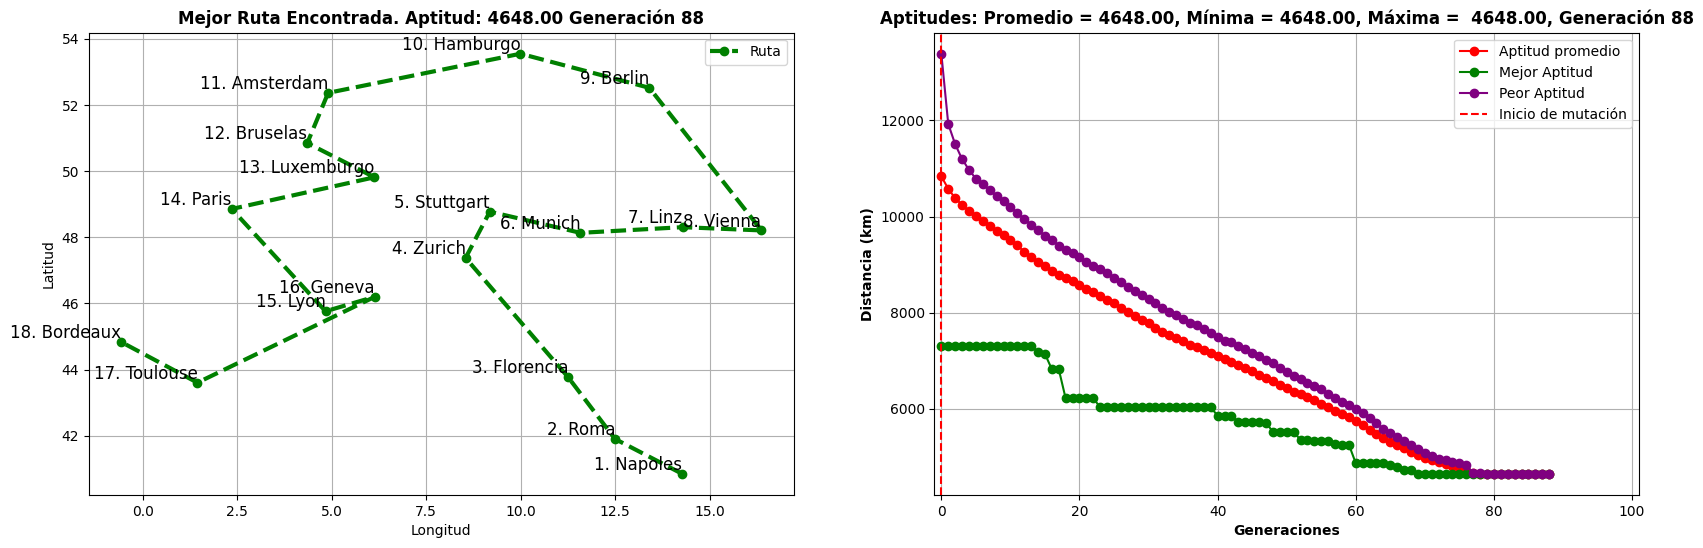

In [35]:
resultados,gen = TSP_alg_genetico(100, poblaciones[1])

In [36]:
resultados["APTITUD"]

0      4648
1      4648
2      4648
3      4648
4      4648
       ... 
495    4648
496    4648
497    4648
498    4648
499    4648
Name: APTITUD, Length: 500, dtype: int64

In [37]:
resultados["POBLACION"][0]

[18, 16, 17, 12, 3, 4, 15, 14, 1, 2, 9, 10, 11, 5, 6, 13, 8, 7]

In [38]:
resultados["RUTA SEGUIDA"][0]

['Nápoles',
 'Roma',
 'Florencia',
 'Zurich',
 'Stuttgart',
 'Munich',
 'Linz',
 'Vienna',
 'Berlin',
 'Hamburgo',
 'Amsterdam',
 'Bruselas',
 'Luxemburgo',
 'Paris',
 'Lyon',
 'Geneva',
 'Toulouse',
 'Bordeaux']